In [11]:
# Import required packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime 
import matplotlib.dates as mdates
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

In [2]:
from matplotlib import rcParams

plt.style.use('ggplot')
rcParams['figure.figsize'] = 12, 5
rcParams['pdf.fonttype'] = 3
rcParams['font.size'] = 10
rcParams['axes.linewidth'] = 2

In [3]:
df = pd.read_csv('./../data/weather_dataset_preprocesado.csv')
load = df['T (degC)']
time = df['datetime']

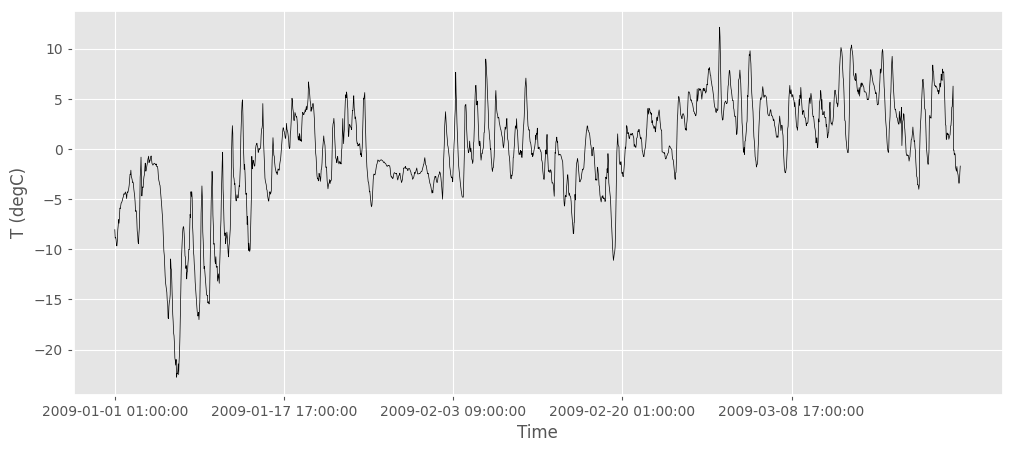

In [4]:
plt.plot(time[:2000], load[:2000], label = 'Real', color = 'k', linewidth = 0.5)
plt.xticks(np.arange(0, 2000, step = 400))
plt.xlabel('Time')
plt.ylabel('T (degC)')
plt.show()

In [5]:
display(load.describe())

count    50224.000000
mean         9.254321
std          8.625312
min        -22.760000
25%          3.140000
50%          9.450000
75%         15.452500
max         35.650000
Name: T (degC), dtype: float64

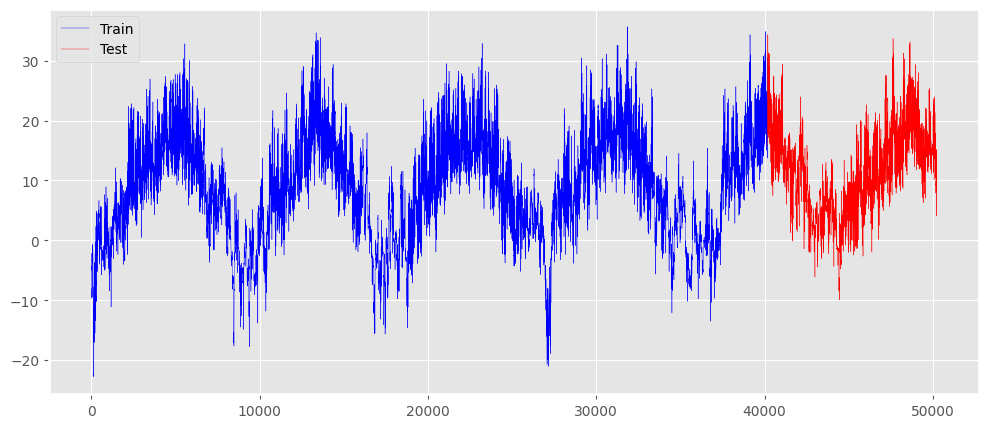

In [7]:
train = load[:int(len(load)*0.8)]
test = load[int(len(load)*0.8):]
plt.plot(train, label='Train', color='blue', linewidth=0.3)
plt.plot(test, label='Test', color='red', linewidth=0.3)
plt.legend()
plt.show()

<Figure size 1200x500 with 0 Axes>

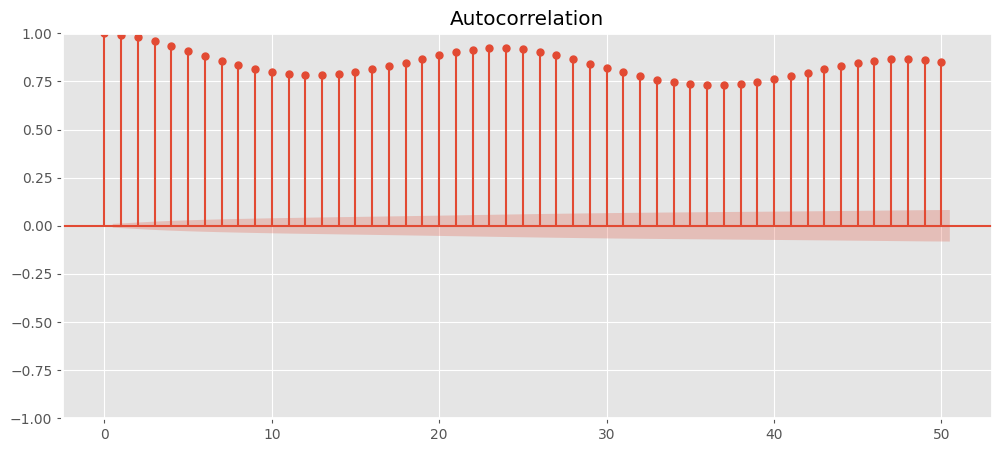

<Figure size 1200x500 with 0 Axes>

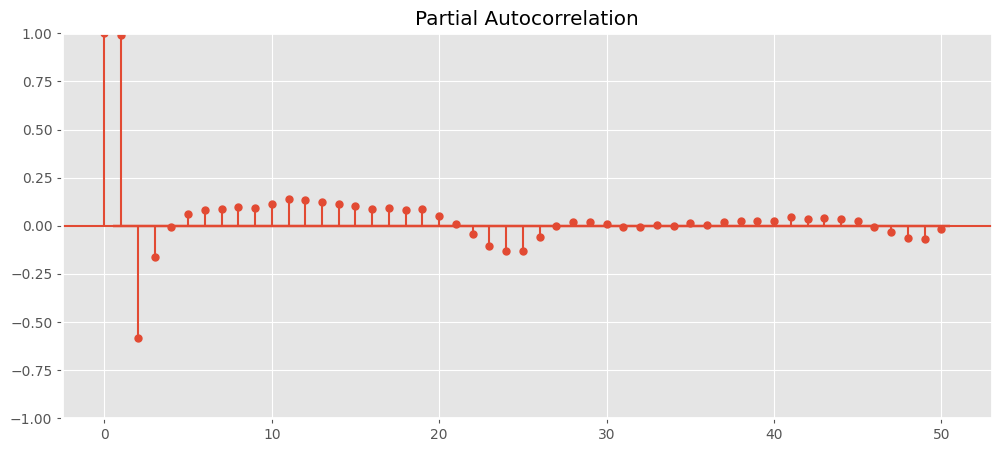

In [9]:
plt.figure()
acf_values = acf(train)
plot_acf(train, lags=50)
plt.show()

plt.figure()
pacf_values = pacf(train)
plot_pacf(train, lags=50)
plt.show()

In [10]:
df_train = pd.DataFrame(train)
df_test = pd.DataFrame(test)
for i in range(1,4):
    df_train["lag{}".format(i)] = df_train["T (degC)"].shift(i)
    df_test["lag{}".format(i)] = df_test["T (degC)"].shift(i)

# df_train = pd.merge(df_train, other_vars_train, left_index=True, right_index=True, how = 'outer')
# df_test = pd.merge(df_test, other_vars_test, left_index=True, right_index=True, how = 'outer')

df_train = df_train.fillna(0)
df_train = df_train.drop(columns = ["T (degC)"])
df_test = df_test.fillna(0)
df_test = df_test.drop(columns = ["T (degC)"])

display(df_train, df_test)

,lag1,lag2,lag3
0,0.00,0.00,0.00
1,-8.05,0.00,0.00
2,-8.88,-8.05,0.00
3,-8.81,-8.88,-8.05
4,-9.05,-8.81,-8.88
...,...,...,...
40174,22.40,23.72,26.45
40175,20.36,22.40,23.72
40176,19.28,20.36,22.40
40177,18.88,19.28,20.36


,lag1,lag2,lag3
40179,0.00,0.00,0.00
40180,15.89,0.00,0.00
40181,16.37,15.89,0.00
40182,18.50,16.37,15.89
40183,21.14,18.50,16.37
...,...,...,...
50219,13.17,10.36,8.01
50220,13.69,13.17,10.36
50221,14.19,13.69,13.17
50222,14.99,14.19,13.69


# ARIMA

In [12]:
# Build Model
arima = ARIMA(train, order=(2, 1, 5)).fit()
print(arima.summary())

c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:               T (degC)   No. Observations:                40179
Model:                 ARIMA(2, 1, 5)   Log Likelihood              -45267.427
Date:                Fri, 04 Oct 2024   AIC                          90550.855
Time:                        19:39:35   BIC                          90619.663
Sample:                             0   HQIC                         90572.630
                              - 40179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9253      0.001   3042.739      0.000       1.924       1.927
ar.L2         -0.9931      0.001  -1600.788      0.000      -0.994      -0.992
ma.L1         -1.6113      0.003   -518.831      0.0

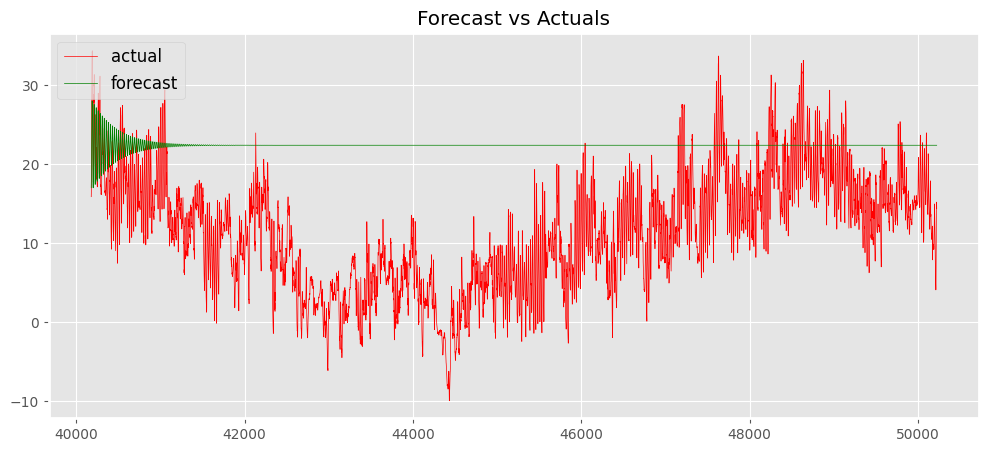

In [13]:
# plotting
arima_fc = arima.forecast(len(test)) 

# Make as pandas series
fc_series = pd.Series(arima_fc, index = [x for x in range(len(train),len(train)+len(test))])
test_series = pd.Series(test, index = [x for x in range(len(train),len(train)+len(test))])
# Plot
# plt.plot(train, label='training', linewidth = 0.5, c = 'b')
plt.plot(test_series, label='actual', linewidth = 0.5, c = 'r')
plt.plot(fc_series, label='forecast', linewidth = 0.5, c = 'g')
# plt.plot(arima.predict(), label = 'fit')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=12)
plt.show()

In [14]:
RMSE_ARIMA = mean_squared_error(test, arima_fc)
MAE_ARIMA  =mean_absolute_error(test, arima_fc)
MAPE_ARIMA = mean_absolute_percentage_error(test, arima_fc)
print('RMSE = {}'.format(RMSE_ARIMA), '\nMAE = {}'.format(MAE_ARIMA), '\nMAPE = {}'.format(MAPE_ARIMA))

RMSE = 174.04448195994527 
MAE = 11.437210072815029 
MAPE = 20079235931655.477


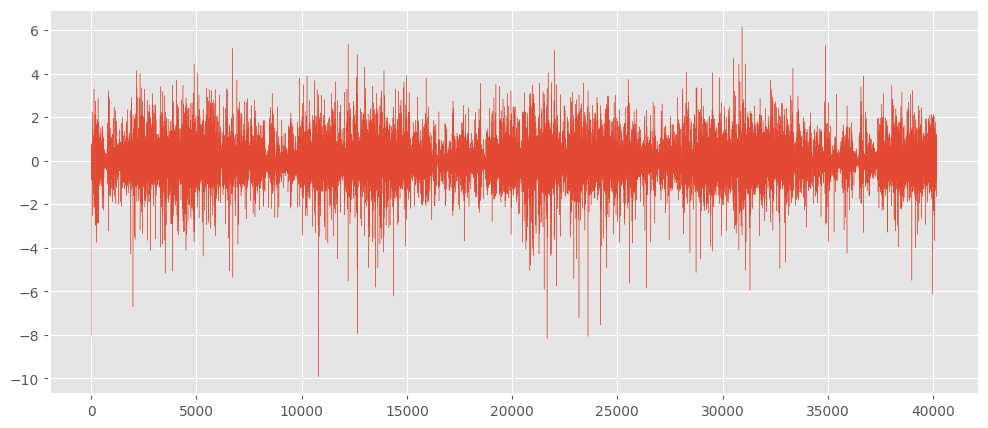

In [15]:
plt.plot(arima.resid, label = 'Residuals', linewidth = 0.3)
# plt.savefig('arimaresid')
plt.show()

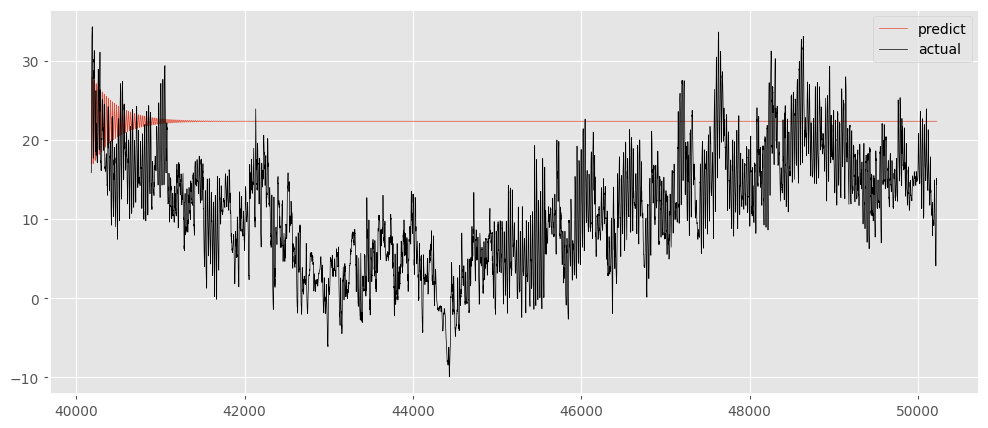

In [16]:
plt.plot(arima_fc, label = 'predict', linewidth = 0.5)
plt.plot(test, label = 'actual', linewidth = 0.5, color = 'k')
plt.legend()
plt.show()

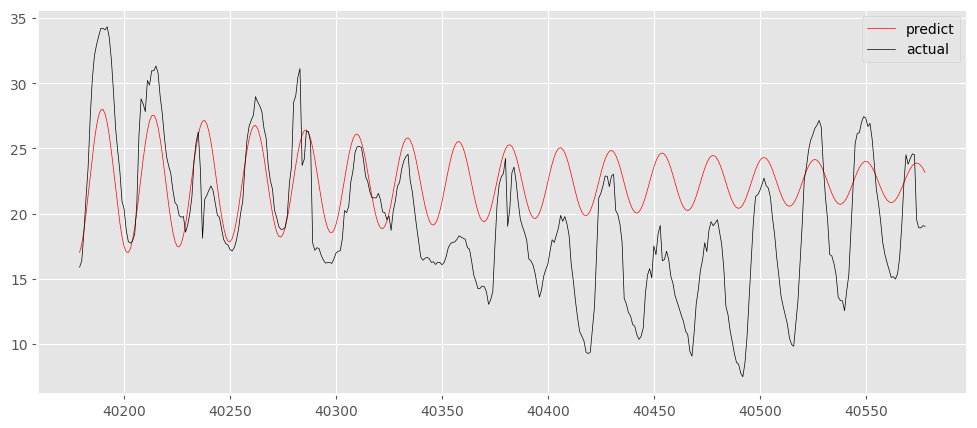

In [17]:
plt.plot(arima_fc[:400], label = 'predict', color = 'r', linewidth = 0.5)
plt.plot(test[:400], label = 'actual', color = 'k', linewidth = 0.5)
plt.legend()
plt.show()

In [18]:
arima_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
arima_SVR.fit(df_train.values, arima.resid)
arima_SVR_fc = arima_SVR.predict(np.array(df_test))

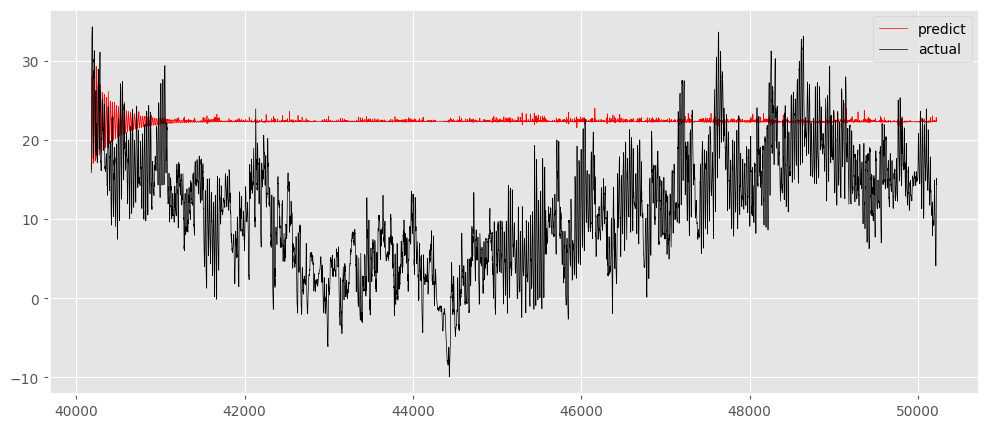

In [19]:
plt.plot(arima_SVR_fc+arima_fc, label = 'predict', linewidth = 0.5, color = 'r')
plt.plot(test, label = 'actual', linewidth = 0.5, color = 'k')
plt.legend()
plt.show()

In [20]:
RMSE_arima_svm = mean_squared_error(test, arima_SVR_fc+arima_fc)
MAE_arima_svm  =mean_absolute_error(test, arima_SVR_fc+arima_fc)
MAPE_arima_svm = mean_absolute_percentage_error(test, arima_SVR_fc+arima_fc)
print('RMSE = {}'.format(RMSE_arima_svm), '\nMAE = {}'.format(MAE_arima_svm), '\nMAPE = {}'.format(MAPE_arima_svm))

RMSE = 174.11879611489877 
MAE = 11.438290544970291 
MAPE = 20104967832935.004


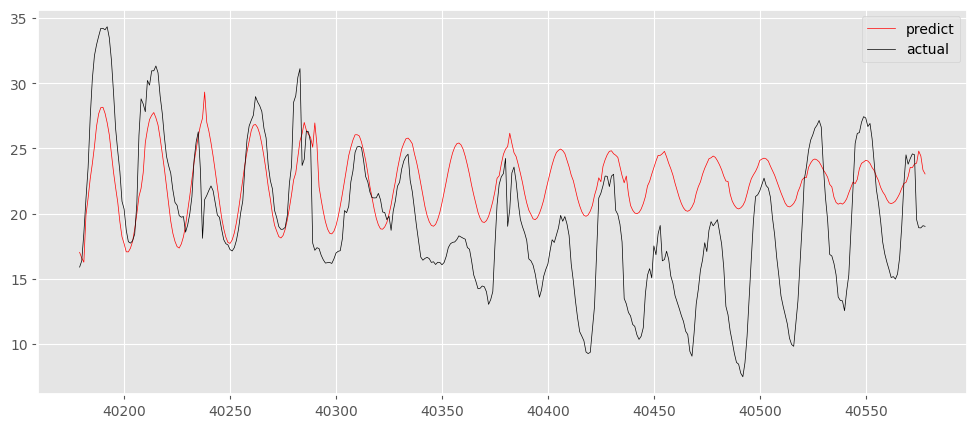

In [21]:
plt.plot(arima_SVR_fc[:400]+arima_fc[:400], label = 'predict', color = 'r', linewidth = 0.5)
plt.plot(test[:400], label = 'actual', color = 'k', linewidth = 0.5)
plt.legend()
plt.show()

# SVM

In [22]:
SVR_m = SVR(kernel = 'rbf', C= 0.5, gamma= 0.01).fit(df_train.values, train)
SVR_fc = SVR_m.predict(np.array(df_test))

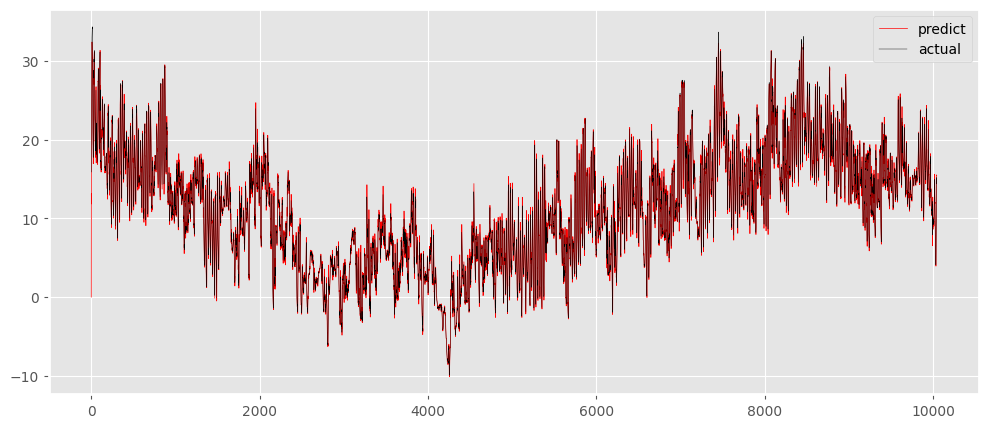

In [24]:
plt.plot(SVR_fc, label = 'predict', linewidth = 0.5, color = 'r')
plt.plot(test.values, label = 'actual', linewidth = 0.3, color = 'k')
plt.legend()
plt.show()

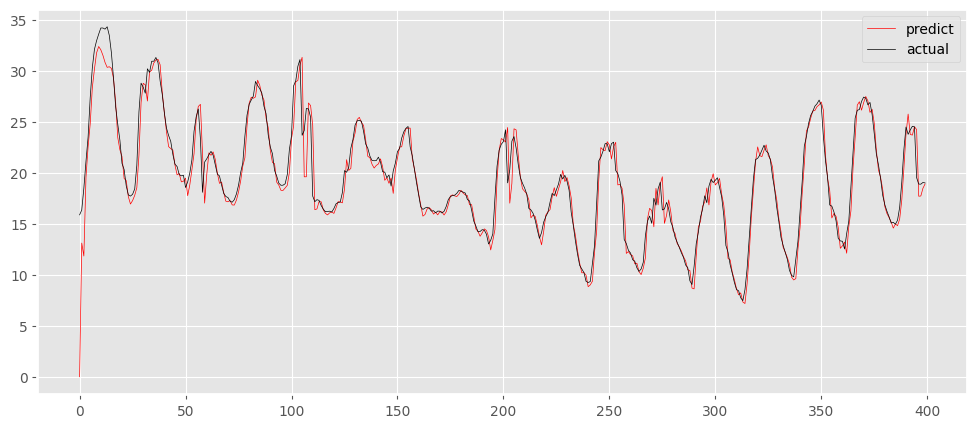

In [25]:
plt.plot(SVR_fc[:400], label = 'predict', color = 'r', linewidth = 0.5)
plt.plot(test.values[:400], label = 'actual', color = 'k', linewidth = 0.5)
plt.legend()
plt.show()

In [26]:
RMSE_SVR = mean_squared_error(test, SVR_fc)
MAE_SVR  =mean_absolute_error(test, SVR_fc)
MAPE_SVR = mean_absolute_percentage_error(test, SVR_fc)
print('RMSE = {}'.format(RMSE_SVR), '\nMAE = {}'.format(MAE_SVR), '\nMAPE = {}'.format(MAPE_SVR))

RMSE = 0.7354349981859446 
MAE = 0.5661032200447094 
MAPE = 122858255992.84724


# Empirical M Decomposition - SVM

In [27]:
!pip install emd

 The argument 'scale_y' is depreciated and will be                         removed in a future version. Please use 'sharey' to remove this                         warning


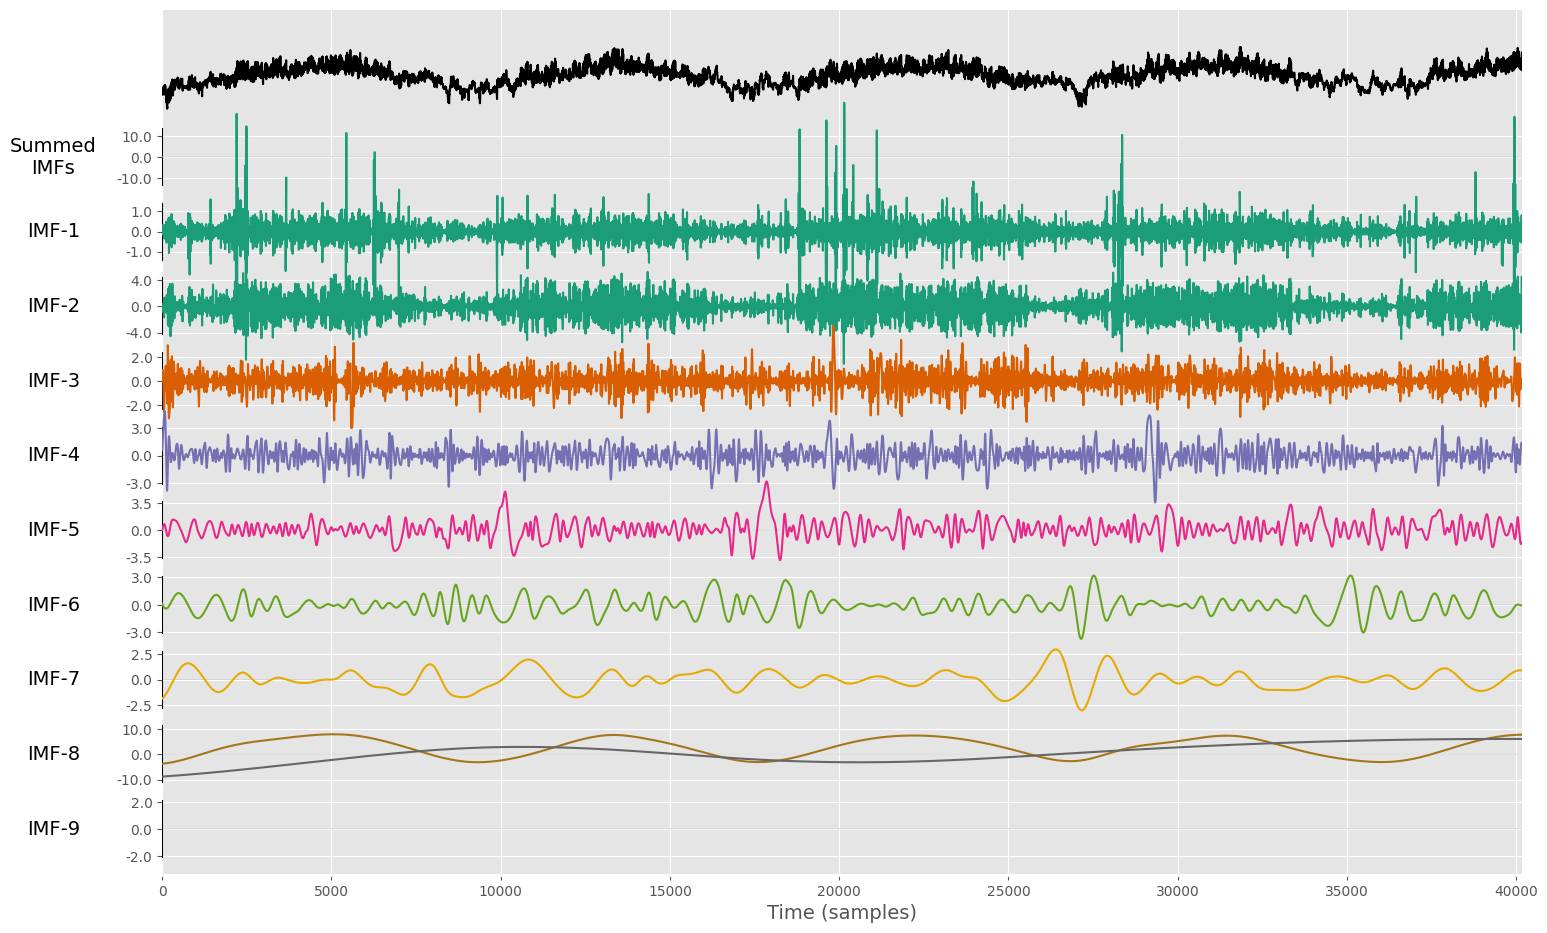

In [28]:
import emd

imf = emd.sift.sift(np.array(train), imf_opts={'sd_thresh': 0.1})
emd.plotting.plot_imfs(imf, cmap=True, scale_y=True)
plt.show()

In [29]:
imf_df = pd.DataFrame(data = imf)
imf_df.columns = ['imf_{}'.format(i+1) for i in range(0, imf.shape[1])]
display(imf_df)

,imf_1,imf_2,imf_3,imf_4,imf_5,imf_6,imf_7,imf_8,imf_9
0,0.624629,0.750155,0.072876,1.124321,-0.065547,0.363817,-3.580026,-11.999043,4.658819
1,-0.245501,0.825166,-0.068872,1.207308,-0.031005,0.344753,-3.574448,-11.996561,4.659159
2,0.070754,0.548892,-0.158437,1.302702,0.003648,0.325833,-3.568823,-11.994069,4.659500
3,0.212963,0.069112,-0.191950,1.409304,0.038389,0.307059,-3.563152,-11.991567,4.659841
4,-0.055081,-0.410446,-0.165875,1.526083,0.073194,0.288431,-3.557434,-11.989054,4.660182
...,...,...,...,...,...,...,...,...,...
40174,-0.262964,-1.162586,-0.007976,2.251873,-3.464818,-0.046511,1.858011,10.987748,10.207223
40175,-0.267115,-2.169806,-0.024808,2.181916,-3.446097,-0.046157,1.856756,10.988102,10.207209
40176,0.181324,-2.944904,-0.044419,2.109394,-3.426769,-0.045749,1.855477,10.988451,10.207195
40177,-0.135689,-3.730243,-0.066740,2.034632,-3.406824,-0.045288,1.854176,10.988795,10.207180


In [30]:
imf1_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf1_SVR.fit(df_train.values, imf_df['imf_1'])
imf1_SVR_fc = imf1_SVR.predict(np.array(df_test))

imf2_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf2_SVR.fit(df_train.values, imf_df['imf_2'])
imf2_SVR_fc = imf2_SVR.predict(np.array(df_test))

imf3_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf3_SVR.fit(df_train.values, imf_df['imf_3'])
imf3_SVR_fc = imf3_SVR.predict(np.array(df_test))

imf4_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf4_SVR.fit(df_train.values, imf_df['imf_4'])
imf4_SVR_fc = imf4_SVR.predict(np.array(df_test))

imf5_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf5_SVR.fit(df_train.values, imf_df['imf_5'])
imf5_SVR_fc = imf5_SVR.predict(np.array(df_test))

imf6_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf6_SVR.fit(df_train.values, imf_df['imf_6'])
imf6_SVR_fc = imf6_SVR.predict(np.array(df_test))

imf7_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf7_SVR.fit(df_train.values, imf_df['imf_7'])
imf7_SVR_fc = imf7_SVR.predict(np.array(df_test))

imf8_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf8_SVR.fit(df_train.values, imf_df['imf_8'])
imf8_SVR_fc = imf8_SVR.predict(np.array(df_test))

imf9_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf9_SVR.fit(df_train.values, imf_df['imf_9'])
imf9_SVR_fc = imf9_SVR.predict(np.array(df_test))

# imf10_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
# imf10_SVR.fit(df_train.values, imf_df['imf_10'])
# imf10_SVR_fc = imf10_SVR.predict(np.array(df_test))

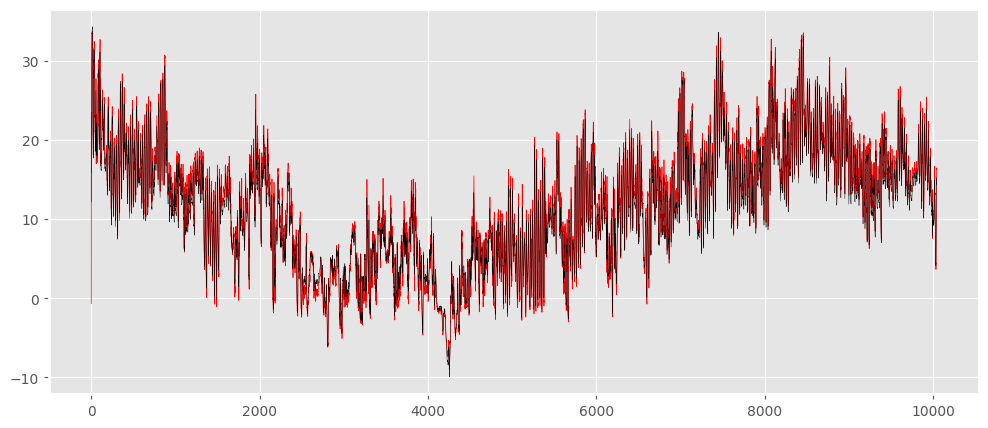

In [31]:
imf_list = ['imf{}_SVR_fc'.format(i) for i in range(1,11)]

imf_fc = np.sum([imf1_SVR_fc, imf2_SVR_fc, imf3_SVR_fc,
                imf4_SVR_fc, imf5_SVR_fc,imf6_SVR_fc,
                imf7_SVR_fc,imf8_SVR_fc,imf9_SVR_fc], axis = 0)

plt.plot(imf_fc, label = 'predict', linewidth = 0.5, color = 'r')
plt.plot(test.values, label = 'actual', linewidth = 0.3, color = 'k')

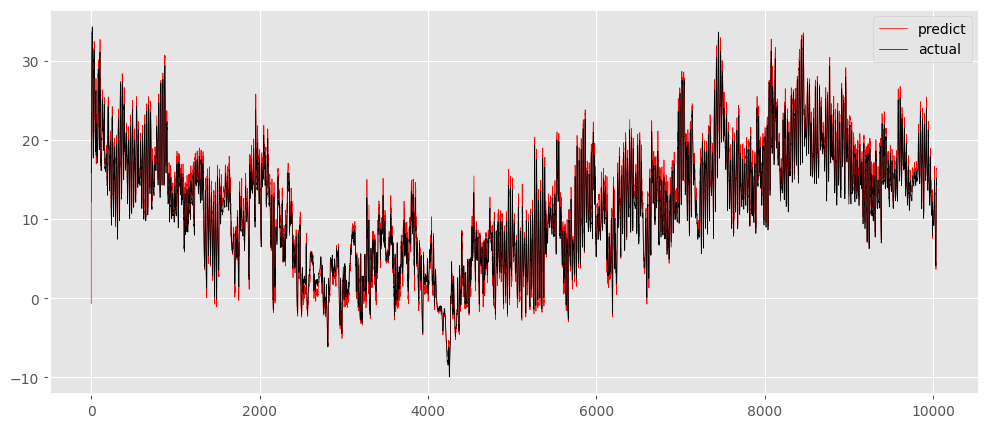

RMSE = 1.7396085192952275 
MAE = 1.0710018070029605 
MAPE = 309357437015.8354


In [32]:
plt.plot(imf_fc,label = 'predict', linewidth = 0.5, color = 'r')
plt.plot(test.values, label = 'actual', linewidth = 0.5, color = 'k')
plt.legend()
plt.show()

RMSE_EMD_SVR = mean_squared_error(test, imf_fc)
MAE_EMD_SVR  =mean_absolute_error(test, imf_fc)
MAPE_EMD_SVR = mean_absolute_percentage_error(test, imf_fc)
print('RMSE = {}'.format(RMSE_EMD_SVR), '\nMAE = {}'.format(MAE_EMD_SVR), '\nMAPE = {}'.format(MAPE_EMD_SVR))

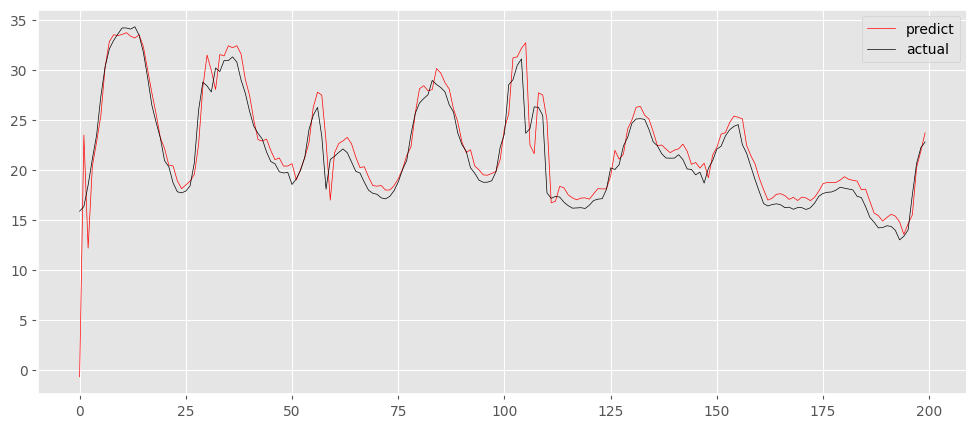

In [33]:
plt.plot(imf_fc[:200], label = 'predict', color = 'r', linewidth = 0.5)
plt.plot(test[:200].values, label = 'actual', color = 'k', linewidth = 0.5)
plt.legend()
plt.show()

In [34]:
imf1_SVR_fc = imf1_SVR.predict(np.array(df_train))
imf2_SVR_fc = imf2_SVR.predict(np.array(df_train))
imf3_SVR_fc = imf3_SVR.predict(np.array(df_train))
imf4_SVR_fc = imf4_SVR.predict(np.array(df_train))
imf5_SVR_fc = imf5_SVR.predict(np.array(df_train))
imf6_SVR_fc = imf6_SVR.predict(np.array(df_train))
imf7_SVR_fc = imf7_SVR.predict(np.array(df_train))
imf8_SVR_fc = imf8_SVR.predict(np.array(df_train))
imf9_SVR_fc = imf9_SVR.predict(np.array(df_train))
# imf10_SVR_fc = imf10_SVR.predict(np.array(df_train))

imf_fc_train = np.sum([imf1_SVR_fc, imf2_SVR_fc, imf3_SVR_fc,
                imf4_SVR_fc, imf5_SVR_fc,imf6_SVR_fc,
                imf7_SVR_fc,imf8_SVR_fc,imf9_SVR_fc], axis = 0)

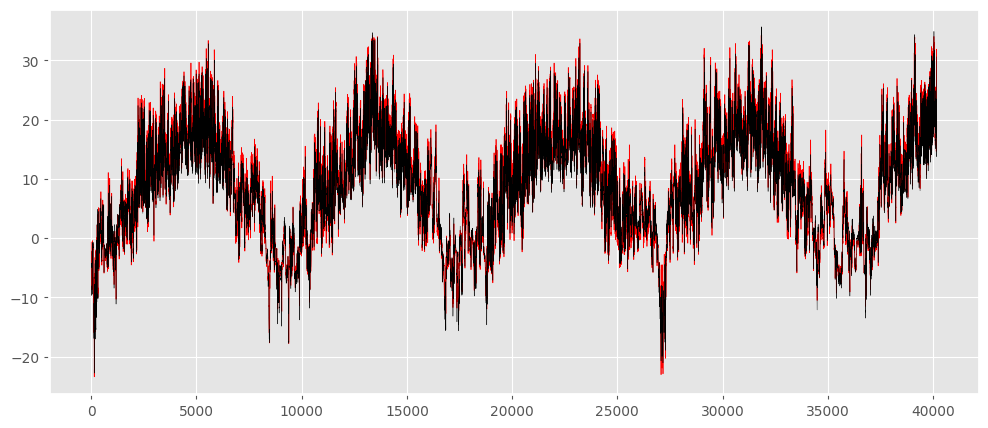

In [35]:
plt.plot(imf_fc_train, label = 'predict', linewidth = 0.5, color = 'r')
plt.plot(train.values, label = 'actual', linewidth = 0.3, color = 'k')

In [36]:
RMSE_EMD_SVR = mean_squared_error(train, imf_fc_train, squared = False)
MAE_EMD_SVR  =mean_absolute_error(train, imf_fc_train)
MAPE_EMD_SVR = mean_absolute_percentage_error(train, imf_fc_train)
print('RMSE = {}'.format(RMSE_EMD_SVR), '\nMAE = {}'.format(MAE_EMD_SVR), '\nMAPE = {}'.format(MAPE_EMD_SVR))

RMSE = 1.2543629882131049 
MAE = 1.0109333198862398 
MAPE = 1955693395238.3962


c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [37]:
import numpy as np
from scipy.optimize import minimize

def dummy(c):
    global  train
    global imf_fc_train
    return mean_squared_error(train, imf_fc_train + c, squared = False)

res = minimize(dummy, 0, method='nelder-mead',
               options={'xatol': 1e-8, 'disp': True})
print(res.x)

Optimization terminated successfully.
         Current function value: 1.168182
         Iterations: 36
         Function evaluations: 73
[-0.45692087]


c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root 

In [38]:
RMSE_EMD_SVR = mean_squared_error(test, imf_fc + res.x[0])
MAE_EMD_SVR  =mean_absolute_error(test, imf_fc + res.x[0])
MAPE_EMD_SVR = mean_absolute_percentage_error(test, imf_fc + res.x[0])
print('RMSE = {}'.format(RMSE_EMD_SVR), '\nMAE = {}'.format(MAE_EMD_SVR), '\nMAPE = {}'.format(MAPE_EMD_SVR))

RMSE = 1.4359235848018885 
MAE = 0.9201904782373754 
MAPE = 719071454039.7024


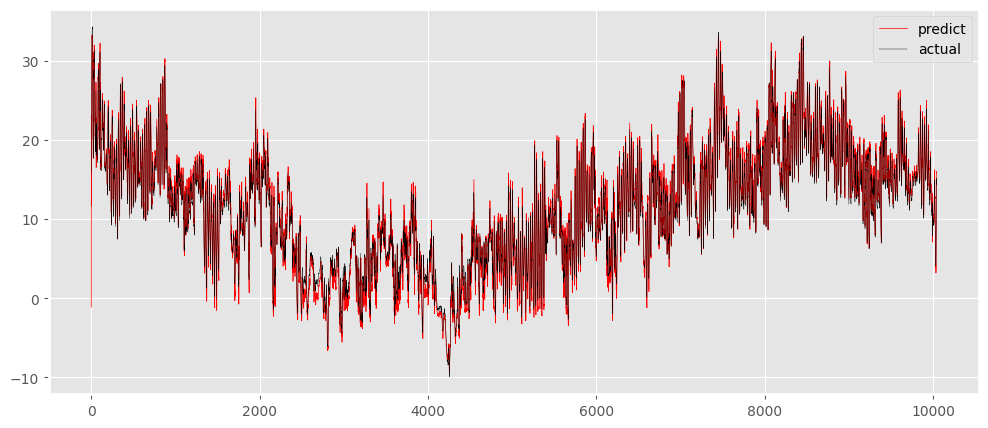

In [39]:
plt.plot(imf_fc + res.x[0], label = 'predict', linewidth = 0.5, color = 'r')
plt.plot(test.values, label = 'actual', linewidth = 0.3, color = 'k')
plt.legend()
plt.show()

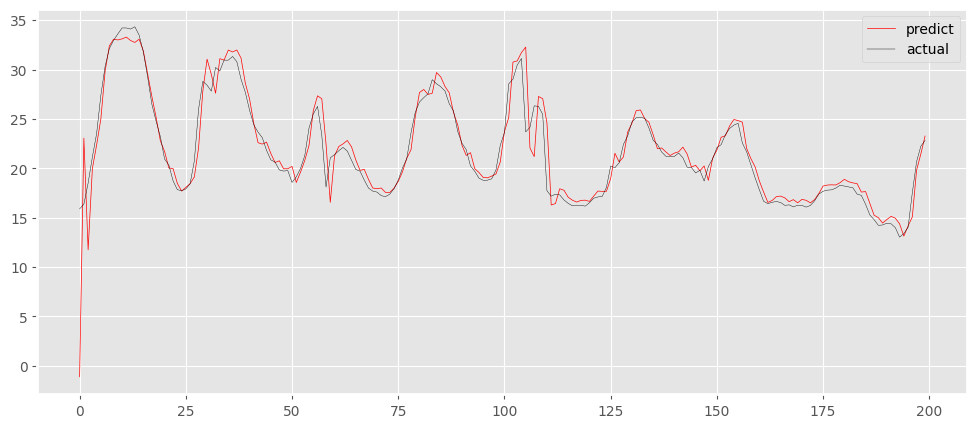

RMSE = 1.4359235848018885 
MAE = 0.9201904782373754 
MAPE = 719071454039.7024


In [40]:
plt.plot(imf_fc[:200] + res.x[0], label = 'predict', linewidth = 0.5, color = 'r')
plt.plot(test.values[:200], label = 'actual', linewidth = 0.3, color = 'k')
plt.legend()
plt.show()
print('RMSE = {}'.format(RMSE_EMD_SVR), '\nMAE = {}'.format(MAE_EMD_SVR), '\nMAPE = {}'.format(MAPE_EMD_SVR))

# EEMD

<Axes: xlabel='Time (samples)'>

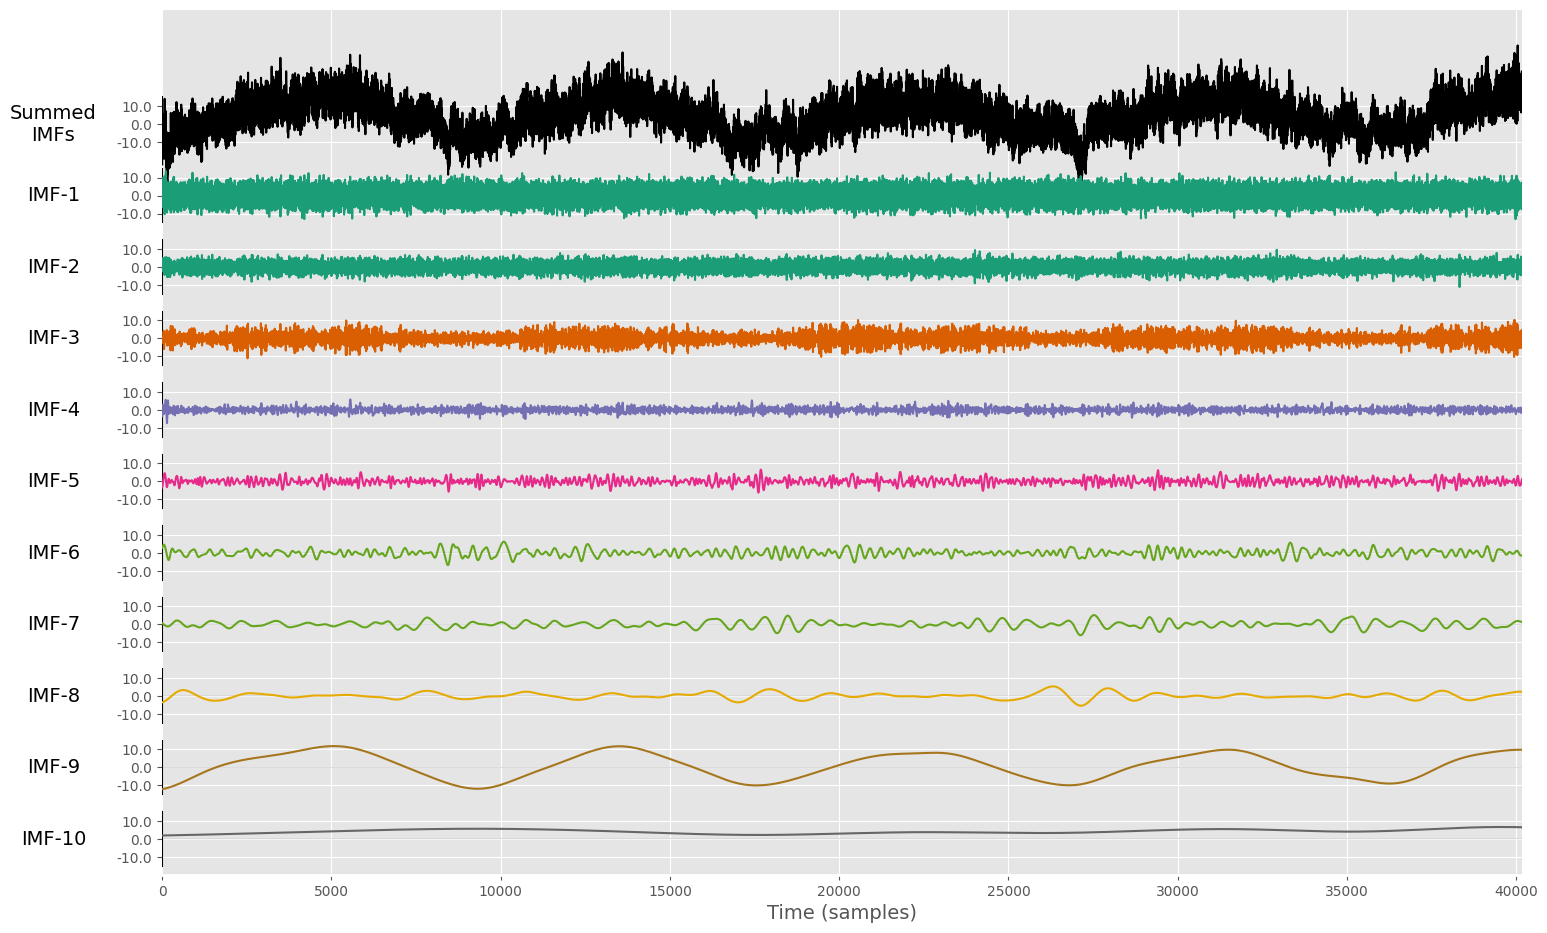

In [96]:
imf_eemd = emd.sift.ensemble_sift(np.array(train), nensembles=4, nprocesses=6, ensemble_noise=1, imf_opts={'sd_thresh': 0.1})
emd.plotting.plot_imfs(imf_eemd)

In [97]:
imf_eemd_df = pd.DataFrame(data = imf_eemd)
imf_eemd_df.columns = ['imf_eemd_{}'.format(i+1) for i in range(0, imf_eemd.shape[1])]
display(imf_eemd_df)

,imf_eemd_1,imf_eemd_2,imf_eemd_3,imf_eemd_4,imf_eemd_5,imf_eemd_6,imf_eemd_7,imf_eemd_8,imf_eemd_9,imf_eemd_10
0,-4.331942,0.439313,-1.348617,-3.490260,-3.386083,2.861804,0.733270,-3.612909,-12.154374,1.861151
1,5.485632,2.631265,-1.844675,-3.067290,-3.337268,2.918846,0.715403,-3.606945,-12.150597,1.861502
2,2.003772,4.327014,-1.982253,-2.559148,-3.277096,2.975406,0.697573,-3.600909,-12.146808,1.861853
3,-0.366368,3.691105,-1.795192,-1.986292,-3.206158,3.031454,0.679780,-3.594801,-12.143008,1.862204
4,-0.541654,2.272671,-1.376886,-1.369233,-3.125047,3.086960,0.662024,-3.588622,-12.139196,1.862556
...,...,...,...,...,...,...,...,...,...,...
40174,5.602053,-1.246748,-2.978582,0.403329,1.352661,-1.317881,1.354690,2.315943,9.774777,6.446397
40175,-6.723058,0.068887,-4.064472,0.292499,1.376330,-1.313261,1.351201,2.314964,9.774354,6.445994
40176,6.362258,0.621993,-4.805311,0.201066,1.390780,-1.308915,1.347800,2.313967,9.773925,6.445592
40177,4.030926,-0.335391,-5.060326,0.136203,1.395776,-1.304870,1.344487,2.312952,9.773491,6.445188


In [99]:
imf1_eemd_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf1_eemd_SVR.fit(df_train.values, imf_eemd_df['imf_eemd_1'])
imf1_eemd_SVR_fc = imf1_eemd_SVR.predict(np.array(df_test))

imf2_eemd_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf2_eemd_SVR.fit(df_train.values, imf_eemd_df['imf_eemd_2'])
imf2_eemd_SVR_fc = imf2_eemd_SVR.predict(np.array(df_test))

imf3_eemd_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf3_eemd_SVR.fit(df_train.values, imf_eemd_df['imf_eemd_3'])
imf3_eemd_SVR_fc = imf3_eemd_SVR.predict(np.array(df_test))

imf4_eemd_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf4_eemd_SVR.fit(df_train.values, imf_eemd_df['imf_eemd_4'])
imf4_eemd_SVR_fc = imf4_eemd_SVR.predict(np.array(df_test))

imf5_eemd_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf5_eemd_SVR.fit(df_train.values, imf_eemd_df['imf_eemd_5'])
imf5_eemd_SVR_fc = imf5_eemd_SVR.predict(np.array(df_test))

imf6_eemd_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf6_eemd_SVR.fit(df_train.values, imf_eemd_df['imf_eemd_6'])
imf6_eemd_SVR_fc = imf6_eemd_SVR.predict(np.array(df_test))

imf7_eemd_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf7_eemd_SVR.fit(df_train.values, imf_eemd_df['imf_eemd_7'])
imf7_eemd_SVR_fc = imf7_eemd_SVR.predict(np.array(df_test))

imf8_eemd_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf8_eemd_SVR.fit(df_train.values, imf_eemd_df['imf_eemd_8'])
imf8_eemd_SVR_fc = imf8_eemd_SVR.predict(np.array(df_test))

imf9_eemd_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf9_eemd_SVR.fit(df_train.values, imf_eemd_df['imf_eemd_9'])
imf9_eemd_SVR_fc = imf9_eemd_SVR.predict(np.array(df_test))

imf10_eemd_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf10_eemd_SVR.fit(df_train.values, imf_eemd_df['imf_eemd_10'])
imf10_eemd_SVR_fc = imf10_eemd_SVR.predict(np.array(df_test))

# imf11_eemd_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
# imf11_eemd_SVR.fit(df_train.values, imf_eemd_df['imf_eemd_11'])
# imf11_eemd_SVR_fc = imf11_eemd_SVR.predict(np.array(df_test))

In [100]:
imf_eemd_list = ['imf{}_eemd_SVR_fc'.format(i) for i in range(1,11)]

imf_eemd_fc = np.sum([imf1_eemd_SVR_fc, imf2_eemd_SVR_fc, imf3_eemd_SVR_fc,
                imf4_eemd_SVR_fc, imf5_eemd_SVR_fc,imf6_eemd_SVR_fc,
                imf7_eemd_SVR_fc,imf8_eemd_SVR_fc,imf9_eemd_SVR_fc, imf10_eemd_SVR_fc], axis = 0)

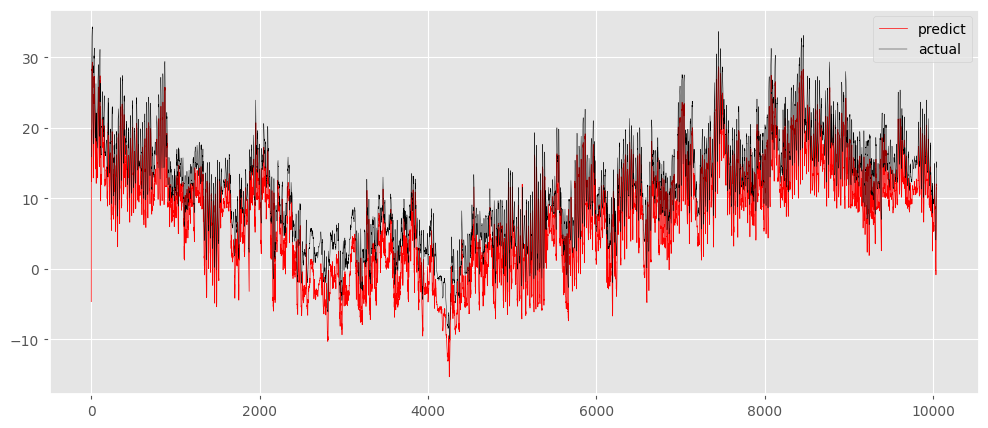

RMSE = 17.146524764454817 
MAE = 3.998496511114926 
MAPE = 4144813517097.487


In [101]:
plt.plot(imf_eemd_fc,label = 'predict', linewidth = 0.5, color = 'r')
plt.plot(test.values, label = 'actual', linewidth = 0.3, color = 'k')
plt.legend()
plt.show()

RMSE_EEMD_SVR = mean_squared_error(test, imf_eemd_fc)
MAE_EEMD_SVR  =mean_absolute_error(test, imf_eemd_fc)
MAPE_EEMD_SVR = mean_absolute_percentage_error(test, imf_eemd_fc)
print('RMSE = {}'.format(RMSE_EEMD_SVR), '\nMAE = {}'.format(MAE_EEMD_SVR), '\nMAPE = {}'.format(MAPE_EEMD_SVR))

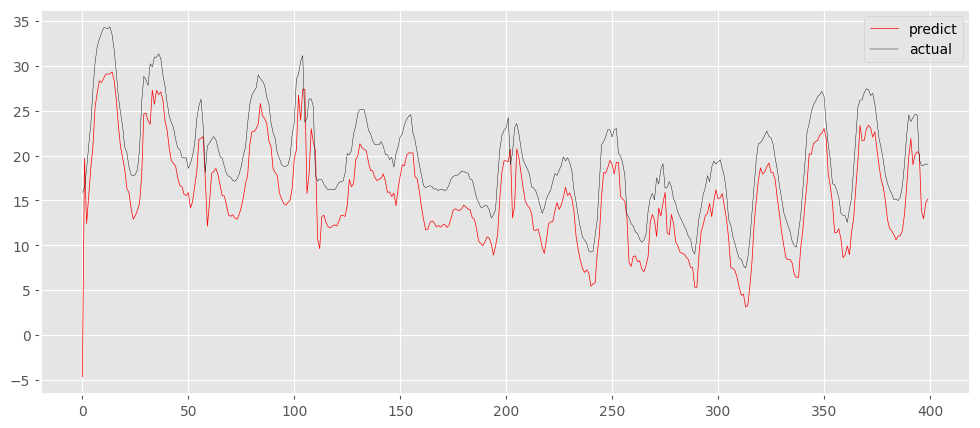

MSE = 17.146524764454817 
MAE = 3.998496511114926 
MAPE = 4144813517097.487


In [102]:
plt.plot(imf_eemd_fc[:400], label = 'predict', linewidth = 0.5, color = 'r')
plt.plot(test[:400].values, label = 'actual', linewidth = 0.3, color = 'k')
plt.legend()
plt.show()

RMSE_EEMD_SVR = mean_squared_error(test, imf_eemd_fc)
MAE_EEMD_SVR  =mean_absolute_error(test, imf_eemd_fc)
MAPE_EEMD_SVR = mean_absolute_percentage_error(test, imf_eemd_fc)
print('MSE = {}'.format(RMSE_EEMD_SVR), '\nMAE = {}'.format(MAE_EEMD_SVR), '\nMAPE = {}'.format(MAPE_EEMD_SVR))

In [103]:
imf1_eemd_SVR_fc = imf1_eemd_SVR.predict(np.array(df_train))
imf2_eemd_SVR_fc = imf2_eemd_SVR.predict(np.array(df_train))
imf3_eemd_SVR_fc = imf3_eemd_SVR.predict(np.array(df_train))
imf4_eemd_SVR_fc = imf4_eemd_SVR.predict(np.array(df_train))
imf5_eemd_SVR_fc = imf5_eemd_SVR.predict(np.array(df_train))
imf6_eemd_SVR_fc = imf6_eemd_SVR.predict(np.array(df_train))
imf7_eemd_SVR_fc = imf7_eemd_SVR.predict(np.array(df_train))
imf8_eemd_SVR_fc = imf8_eemd_SVR.predict(np.array(df_train))
imf9_eemd_SVR_fc = imf9_eemd_SVR.predict(np.array(df_train))
imf10_eemd_SVR_fc = imf10_eemd_SVR.predict(np.array(df_train))
# imf11_eemd_SVR_fc = imf11_eemd_SVR.predict(np.array(df_train))

imf_eemd_fc_train = np.sum([imf1_eemd_SVR_fc, imf2_eemd_SVR_fc, imf3_eemd_SVR_fc,
                imf4_eemd_SVR_fc, imf5_eemd_SVR_fc,imf6_eemd_SVR_fc,
                imf7_eemd_SVR_fc,imf8_eemd_SVR_fc,imf9_eemd_SVR_fc, imf10_eemd_SVR_fc], axis = 0)

In [104]:
def dummy1(c):
    global train
    global imf_eemd_fc_train
    return mean_squared_error(train, imf_eemd_fc_train + c)

res1 = minimize(dummy1, 0, method='nelder-mead',
               options={'xatol': 1e-8, 'disp': True})
print(res1.x)

Optimization terminated successfully.
         Current function value: 1.108753
         Iterations: 42
         Function evaluations: 84
[4.0660542]


In [105]:
RMSE_EEMD_SVR = mean_squared_error(test, imf_eemd_fc + res1.x[0])
MAE_EEMD_SVR  =mean_absolute_error(test, imf_eemd_fc + res1.x[0])
MAPE_EEMD_SVR = mean_absolute_percentage_error(test, imf_eemd_fc + res1.x[0])
print('RMSE = {}'.format(RMSE_EEMD_SVR), '\nMAE = {}'.format(MAE_EEMD_SVR), '\nMAPE = {}'.format(MAPE_EEMD_SVR))

RMSE = 1.2337602180289315 
MAE = 0.8361976607042342 
MAPE = 498844343085.31665


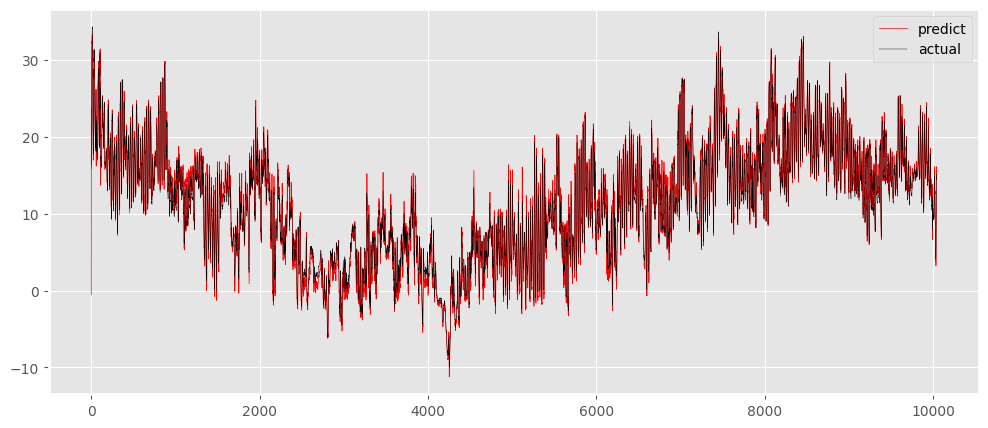

In [106]:
plt.plot(imf_eemd_fc + res1.x[0], label = 'predict', linewidth = 0.5, color = 'r')
plt.plot(test.values, label = 'actual', linewidth = 0.3, color = 'k')
plt.legend()
plt.show()

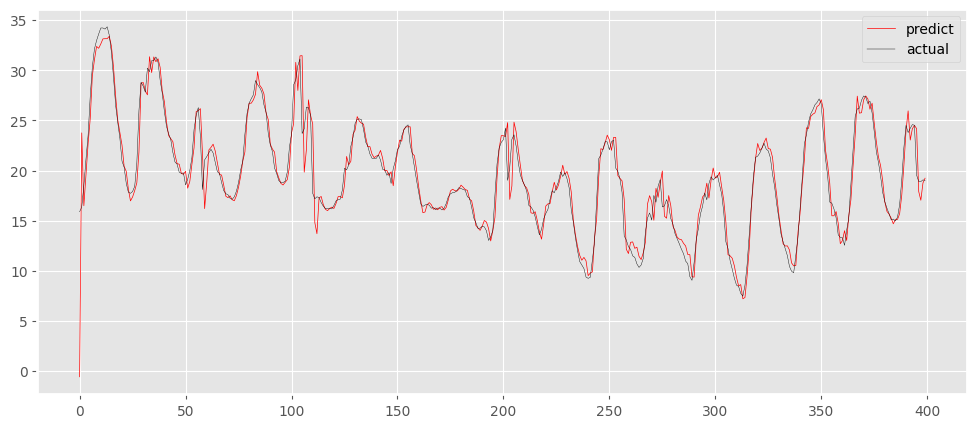

In [108]:
plt.plot(imf_eemd_fc[:400] + res1.x[0], label = 'predict', linewidth = 0.5, color = 'r')
plt.plot(test.values[:400], label = 'actual', linewidth = 0.3, color = 'k')
plt.legend()
plt.show()

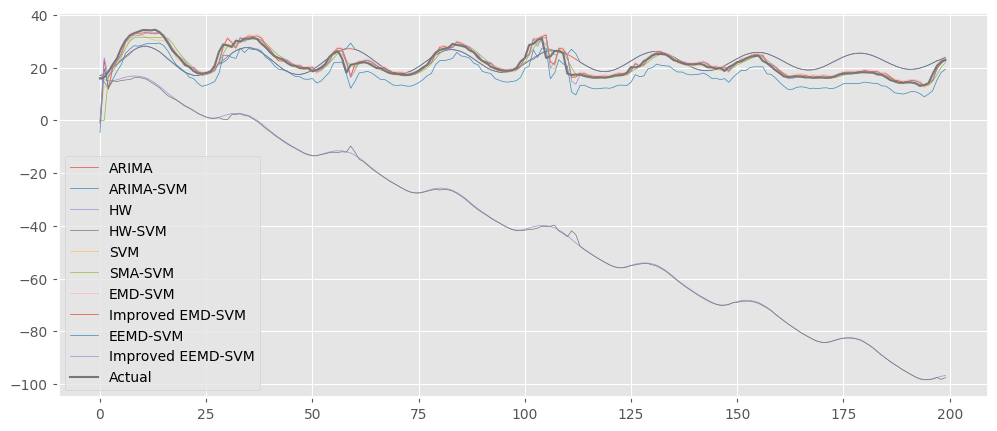

In [110]:
plt.plot(arima_fc.values[:200], label = 'ARIMA', linewidth = 0.5)
plt.plot(arima_SVR_fc[:200]+arima_fc.values[:200], label = 'ARIMA-SVM', linewidth = 0.5)
plt.plot(hw_fc.values[:200], label = 'HW', linewidth = 0.5)
plt.plot(hw_SVR_fc[:200]+hw_fc.values[:200], label = 'HW-SVM', linewidth = 0.5)
plt.plot(SVR_fc[:200], label = 'SVM', linewidth = 0.5)
plt.plot(SVR_MA_3_fc[0:200], label = 'SMA-SVM', linewidth = 0.5)
plt.plot(imf_fc[:200], label = 'EMD-SVM', linewidth = 0.5)
plt.plot(imf_fc[:200] + res.x[0], label = 'Improved EMD-SVM', linewidth = 0.5)
plt.plot(imf_eemd_fc[:200], label = 'EEMD-SVM', linewidth = 0.5)
plt.plot(imf_eemd_fc[:200] + res1.x[0], label = 'Improved EEMD-SVM', linewidth = 0.5)
plt.plot(test.values[:200], label = 'Actual')
plt.legend()
plt.show()

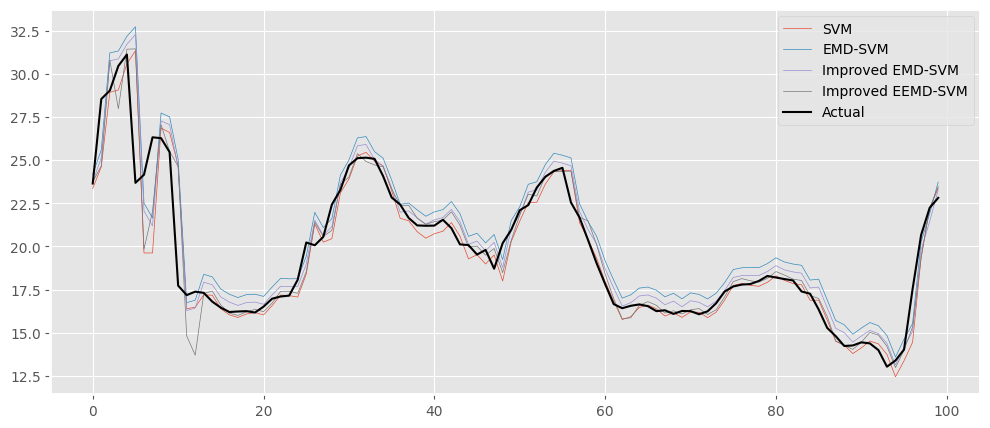

In [116]:
start = 100
end = 200

plt.plot(SVR_fc[start:end], label = 'SVM', linewidth = 0.5)
plt.plot(imf_fc[start:end], label = 'EMD-SVM', linewidth = 0.5)
plt.plot(imf_fc[start:end] + res.x[0], label = 'Improved EMD-SVM', linewidth = 0.5)
# plt.plot(imf_eemd_fc[start:end], label = 'EEMD-SVM', linewidth = 0.5)
plt.plot(imf_eemd_fc[start:end] + res1.x[0], label = 'Improved EEMD-SVM', linewidth = 0.5)
plt.plot(test.values[start:end], label = 'Actual', c = 'k')
plt.legend()
plt.show()

2. Descomposición Empírica en Modo (EEMD)

<Axes: xlabel='Time (samples)'>

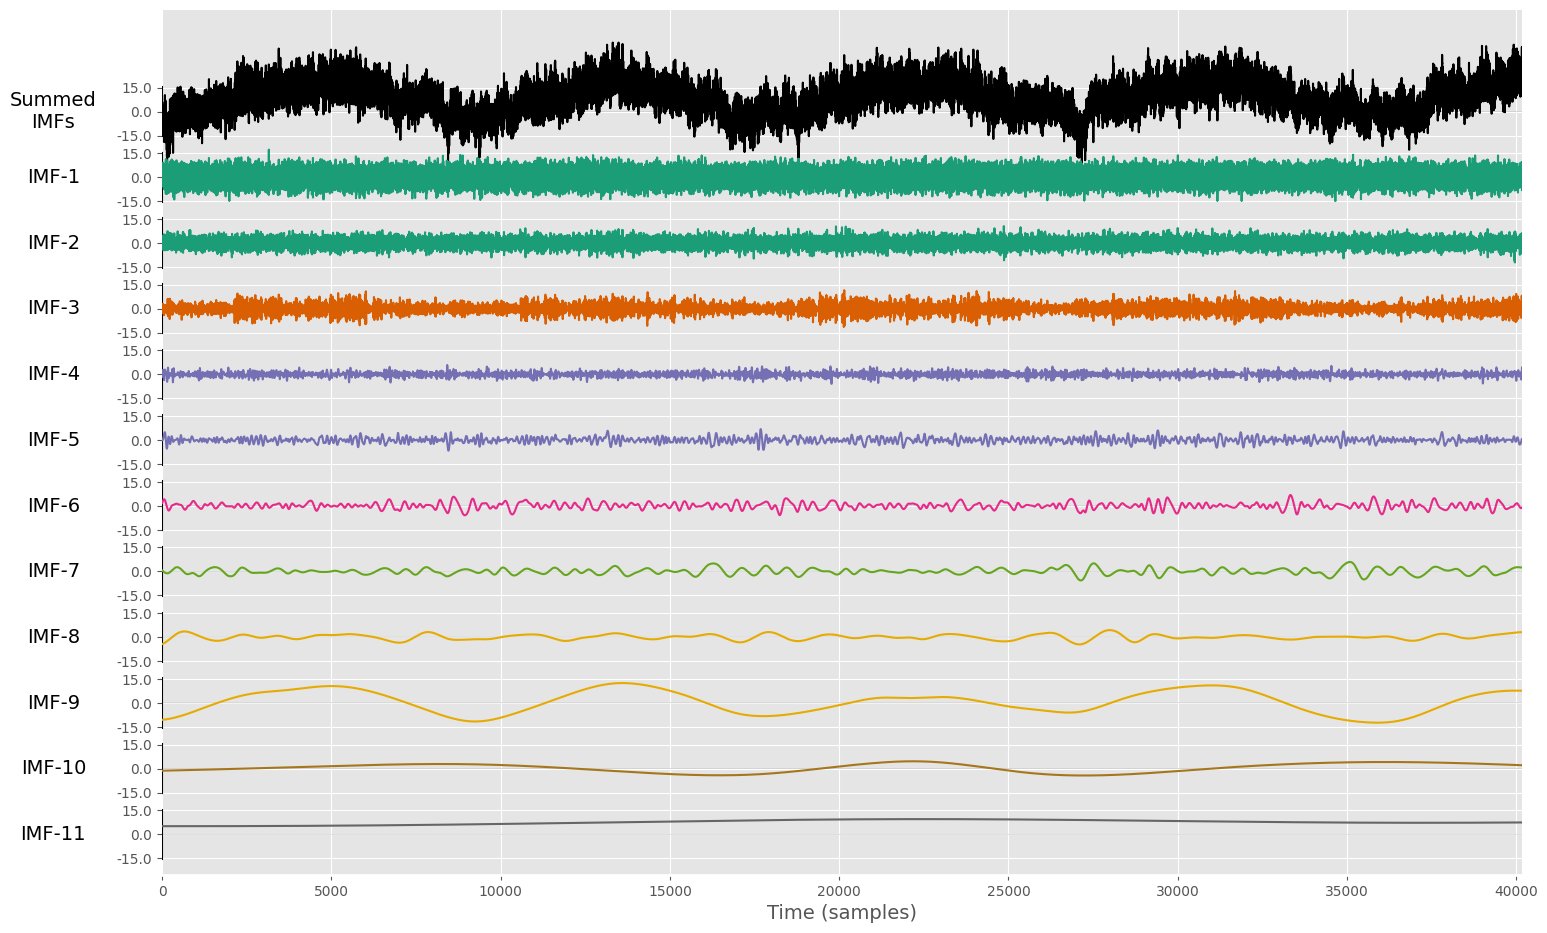

In [41]:
import numpy as np
import pandas as pd
import emd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from scipy.optimize import minimize

# Realizar la descomposición EEMD
imf_eemd = emd.sift.ensemble_sift(np.array(train), nensembles=4, nprocesses=6, ensemble_noise=1, imf_opts={'sd_thresh': 0.1})
emd.plotting.plot_imfs(imf_eemd)

3. Conversión de IMFs a DataFrame

In [42]:
imf_eemd_df = pd.DataFrame(data=imf_eemd)
imf_eemd_df.columns = ['imf_eemd_{}'.format(i+1) for i in range(0, imf_eemd.shape[1])]
display(imf_eemd_df)

,imf_eemd_1,imf_eemd_2,imf_eemd_3,imf_eemd_4,imf_eemd_5,imf_eemd_6,imf_eemd_7,imf_eemd_8,imf_eemd_9,imf_eemd_10,imf_eemd_11
0,-1.049114,1.393219,-0.034049,-1.400059,-0.116458,1.720341,0.652670,-4.300235,-10.598501,-1.304328,5.057764
1,2.555520,2.229263,0.257952,-1.318520,-0.127800,1.784000,0.631196,-4.292402,-10.596455,-1.303895,5.057748
2,0.280034,2.904635,0.334331,-1.216466,-0.135177,1.847448,0.609812,-4.284499,-10.594398,-1.303463,5.057732
3,-0.525785,1.874501,0.128628,-1.094426,-0.138865,1.910644,0.588520,-4.276525,-10.592331,-1.303030,5.057717
4,-0.382453,-0.262609,-0.274336,-0.953665,-0.139035,1.973543,0.567320,-4.268481,-10.590254,-1.302598,5.057701
...,...,...,...,...,...,...,...,...,...,...,...
40174,-1.031127,-1.265093,-1.251928,4.379075,0.749195,-1.102592,2.412050,3.107201,7.589808,2.096166,7.382486
40175,4.327442,-0.375866,-1.545737,4.270908,0.728365,-1.077812,2.408816,3.107141,7.589240,2.095364,7.382617
40176,-2.990076,-2.175715,-1.510536,4.090912,0.697702,-1.052380,2.405578,3.107072,7.588668,2.094563,7.382748
40177,-0.079489,-3.880882,-1.132004,3.844699,0.657358,-1.026310,2.402334,3.106994,7.588094,2.093761,7.382879


4. Construcción y Ajuste de Modelos ARIMA para Cada IMF

In [43]:
imf_arima_models = []
imf_arima_forecasts = []

for i in range(imf_eemd.shape[1]):
    imf_series = imf_eemd_df['imf_eemd_{}'.format(i+1)]
    model = ARIMA(imf_series, order=(2, 1, 5)).fit()
    imf_arima_models.append(model)
    forecast = model.forecast(len(test))
    imf_arima_forecasts.append(forecast)

c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\statsmodels\t

5. Suma de las Predicciones de los IMFs

In [44]:
imf_arima_fc = np.sum(imf_arima_forecasts, axis=0)

6. Predicciones para el Conjunto de Entrenamiento

In [45]:
imf_arima_train_forecasts = []

for i in range(imf_eemd.shape[1]):
    model = imf_arima_models[i]
    forecast = model.predict(start=0, end=len(train)-1)
    imf_arima_train_forecasts.append(forecast)

imf_arima_fc_train = np.sum(imf_arima_train_forecasts, axis=0)

7. Optimización de la Predicción

In [46]:
def dummy1(c):
    global train
    global imf_arima_fc_train
    return mean_squared_error(train, imf_arima_fc_train + c)

res1 = minimize(dummy1, 0, method='nelder-mead', options={'xatol': 1e-8, 'disp': True})
print(res1.x)

Optimization terminated successfully.
         Current function value: 13.833755
         Iterations: 21
         Function evaluations: 44
[-0.00233649]


8. Graficar las Predicciones

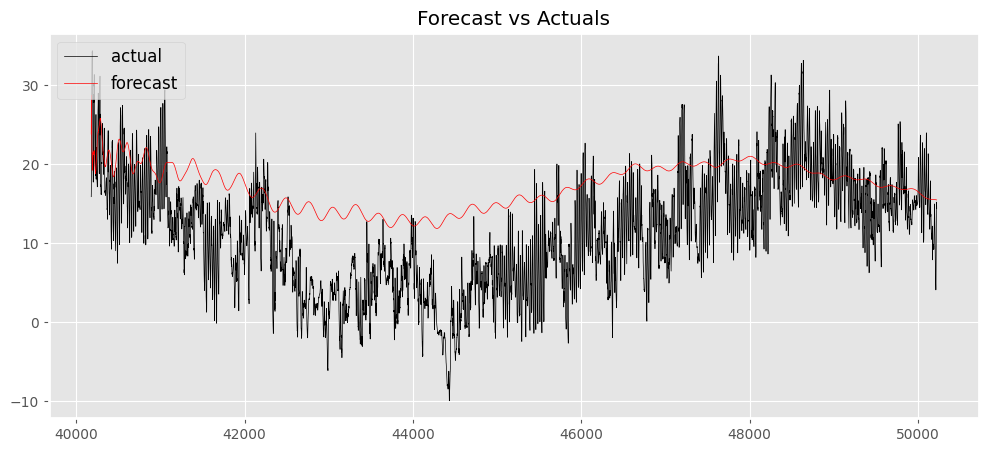

RMSE = 67.59808824720292 
MAE = 6.926893181853979 
MAPE = 12512688765354.213


In [49]:
# Ajustar las predicciones con el valor óptimo de c
imf_arima_fc += res1.x

# Convertir las predicciones y los datos de prueba en series de pandas
fc_series = pd.Series(imf_arima_fc, index=[x for x in range(len(train), len(train) + len(test))])
test_series = pd.Series(test, index=[x for x in range(len(train), len(train) + len(test))])

# Graficar las predicciones y los datos reales
plt.plot(test_series, label='actual', linewidth=0.5, c='k')
plt.plot(fc_series, label='forecast', linewidth=0.5, c='r')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=12)
plt.show()

# Calcular y mostrar las métricas de error
RMSE_ARIMA = mean_squared_error(test, imf_arima_fc)
MAE_ARIMA = mean_absolute_error(test, imf_arima_fc)
MAPE_ARIMA = mean_absolute_percentage_error(test, imf_arima_fc)
print('RMSE = {}'.format(RMSE_ARIMA), '\nMAE = {}'.format(MAE_ARIMA), '\nMAPE = {}'.format(MAPE_ARIMA))